x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
Normal train shape: (6742, 28, 28, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 64)             │       219,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 28, 28, 1)      │       259,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.4530 - val_loss: 0.1330
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 0.1225 - val_loss: 0.0801
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 0.0785 - val_loss: 0.0657
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0623 - val_loss: 0.0525
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 0.0524 - val_loss: 0.0474
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 0.0475 - val_loss: 0.0454
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0456 - val_loss: 0.0439
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - loss: 0.0439 - val_loss: 0.0429
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - loss: 0.0432 - val_loss: 0.0423
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 0.0422 - val_loss: 0.0418
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


Anomaly threshold: 0.00598213190383294
Model and threshold saved successfully
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


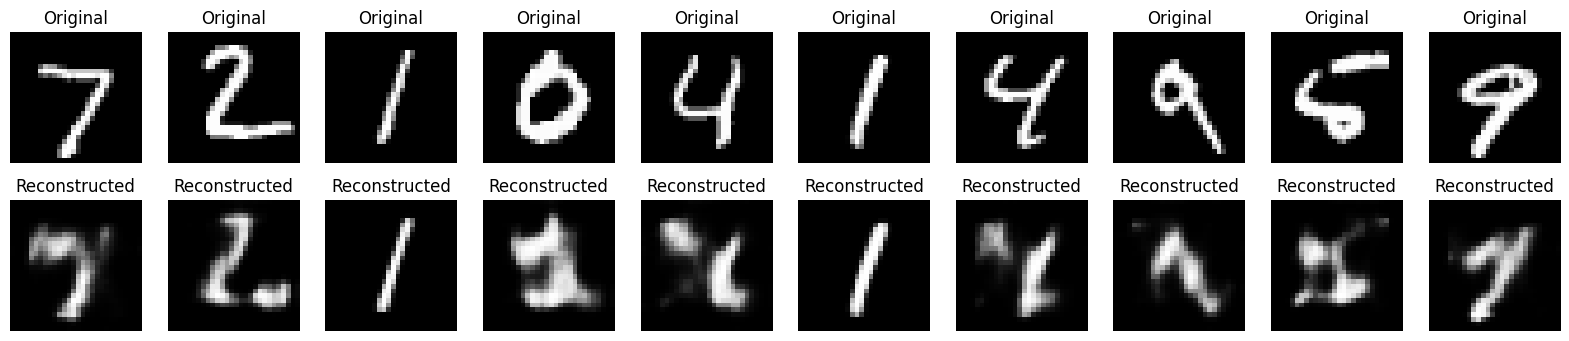

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train/255.0
x_test = x_test/255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

########
normal_class = 1
x_train_normal = x_train[y_train == normal_class]
x_test_normal = x_test[y_test == normal_class]

print("Normal train shape:", x_train_normal.shape)

encoder = models.Sequential([layers.InputLayer(input_shape=(28,28,1)),
                             layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
                             layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
                             layers.Flatten(),
                             layers.Dense(64, activation='relu')])

decoder = models.Sequential([layers.InputLayer(input_shape=(64,)),
                           layers.Dense(7*7*64, activation='relu'), # Adjusted Dense layer size
                           layers.Reshape((7,7,64)), # Adjusted Reshape to match the Dense layer size
                           layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2),
                           layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2), # Adjusted Conv2DTranspose filters
                           layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')])


autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

########
autoencoder.fit(
    x_train_normal,
    x_train_normal,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_normal, x_test_normal)
)

reconstructed = autoencoder.predict(x_train_normal)
mse = np.mean((x_train_normal - reconstructed) ** 2, axis=(1, 2, 3))

threshold = np.percentile(mse, 95)
print("Anomaly threshold:", threshold)

autoencoder.save("autoencoder.h5")
np.save("threshold.npy", threshold)

print("Model and threshold saved successfully")

decoded_images = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20,4))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i].reshape(28,28), cmap = "gray")
  plt.title('Original')
  plt.gray()
  ax.axis('off')

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_images[i].reshape(28,28), cmap ="gray")
  plt.title('Reconstructed')
  plt.gray()
  ax.axis('off')

plt.show()

In [7]:
from google.colab import files

files.download("autoencoder.h5")
files.download("threshold.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>